# 胶囊网络指南

本文参考该英文[指南](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-capsule-networks/notebook)，翻译并补充内容。

本笔记本使用 Keras 介绍并实现胶囊网络 (CapsNet)，并在 DonorsChoose.Org 的竞赛中评估了其性能。
文中提供的示例仅用于促进对模型的理解。

胶囊网络最初在 2017 年由 Hinton 等人的《Dynamic Routing Between Capsules》提出。

## 目录

- 胶囊网络介绍
    - 人类视觉识别
    - CNN 的缺陷
    - 胶囊

## 胶囊网络介绍

### 人类视觉识别

任何现实的对象都可以认为是由几个较小的对象组成。例如，一棵树由树干，树冠和根组成。这些部分形成层次结构。一棵树的树冠进一步由树枝组成，树枝上有叶子。

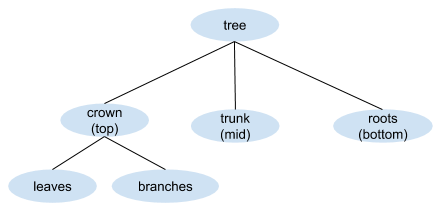

每当我们看到某个物体时，我们的眼睛就会注视一些固定点，这些固定点的相对位置和性质有助于我们的大脑识别该物体。这样，我们的大脑不必处理所有细节。仅仅看到一些树叶和树枝，我们的大脑就会意识到树冠。冠立在树干上，树干下面有一些根。结合这些分层信息，我们的大脑就会意识到有一棵树。由此，我们将对象的各个部分称为实体。

### 胶囊

胶囊网络模型背后的假设是，存在胶囊（一组神经元）来告诉图像中是否存在某些对象（**实体**）。对应于每个实体，都有一个胶囊，它给出：

- 实体存在于图像中的概率
- 该实体的**实例化参数**(instantiation parameters)

实例化参数是图像中该实体的属性（例如“位置”、“大小”、“色相”等）。例如，矩形是一个简单的几何对象。对应于矩形的胶囊将告诉我们其实例化参数。

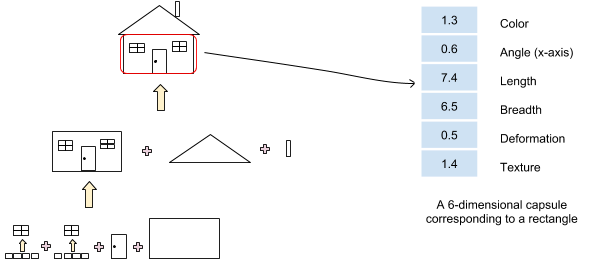

从上图中可见，我们假想的胶囊由 6 个神经元组成，每个神经元对应于矩形的某些属性，一组神经元的值对应一个向量，称为**激活向量**。该向量的长度表示的是矩阵存在的可能性。因此，矩形存在的可能性可写作：

$$
\sqrt{1.3^{2} + 0.6^{2} + 7.4^{2} + 6.5^{2} + 0.5^{2} + 1.4^{2}} = 10.06
$$

但是，如果使用概率来表示可能性，这个值应该在 0 到 1 的范围内。因此胶囊的输出需要进行如下转换：

$$
\begin{equation}
\mathbf{v}_{j}=\frac{\left\|\mathbf{s}_{j}\right\|^{2}}{1+\left\|\mathbf{s}_{j}\right\|^{2}}  \frac{\mathbf{s}_{j}}{\left\|\mathbf{s}_{j}\right\|}
\end{equation}
$$

这个非线性变换被称为压缩函数 (squashing function)，它充当胶囊网络的激活函数，如果 CNN 中使用的 ReLU。



### 按协议路由

一个胶囊网络由若干层组成。低层的胶囊对应于简单的实体（例如，矩形、三角形）。这些低级的胶囊推断存在更复杂的实体，并且它们的推断被“组合”以产生高级胶囊（例如，房屋的门、窗）的输出。例如，存在一个*矩形*（x轴角度 = 0，大小 = 5，位置 = 0，...）和*三角形*（x轴角度 = 6，大小 = 5，位置 = 5，...）共同推断一座*房屋*的存在（更高层的实体）。

需要注意的是，胶囊网络中，胶囊之间可能有**耦合作用** (coupling effect)。当一个低层级的胶囊成功学习到一个高层级实体时，该实体对应的高层级胶囊将反馈发送到这些低层级胶囊，从而增加其在该高级别胶囊上的推测。为理解这一点，我们假设有这样两层胶囊：

- 低层对应于矩形，三角形和圆形
- 高层对应于房屋，船只和汽车

如果一个图像包含房屋，则网络中对应于矩形和三角形的胶囊将具有较大的激活向量。它们的相对位置（编码在其实例化参数中）将取决于高级对象。由于它们将就房屋的存在达成一致，房屋胶囊的输出向量将变大。反过来，这将使矩形和三角形胶囊所得的预测值更大。此循环将重复 4-5 次，之后对房屋存在的推测概率将比对船或汽车存在的推测概率要大得多。

### 胶囊网络的数学推导

假设第 $l$ 层和第 $l + 1$ 层分别有 $m$ 和 $n$ 个胶囊，我们的任务是根据第 $l$ 层的激活值计算第 $l + 1$ 层的激活值。令 $u$ 表示第 $l$ 层的激活值，我们计算的是第 $l + 1$ 层的激活值 $v$。

对于第 $l + 1$ 层的胶囊 $j$：

1. 首先通过第 $l$ 层计算**预测向量**。第 $l$ 层胶囊 $i$ 提供给第 $l + 1$ 层的胶囊 $j$ 的预测向量是：
$$
\hat{\mathbf{u}_{j | i}}=\mathbf{W}_{i j} \mathbf{u}_{i}
$$
$\mathbf{W}_{i j}$ 是待学习的权重矩阵。

2. 然后计算胶囊 $j$ 的**输出向量**。输出向量是第 $l$ 层胶囊对胶囊 $j$ 给出的所有预测向量的加权和。
$$
s_{j}=\sum_{i=1}^{m} c_{i j} \hat{\mathbf{u}_{j | i}}
$$
标量 $\mathbf{c}_{ij}$ 被称为第 $l$ 层胶囊 $i$ 和第 $l + 1$ 层胶囊 $j$ 之间的耦合系数。这些系数由**迭代动态路由算法**确定。

3. 对输出向量应用压缩函数，来获得胶囊 $j$ 的激活向量 $\mathbf{v}_j$：
$$
\mathbf{v}_{j}=\text{ squash}\left(\mathbf{s}_{j}\right)
$$

## 参考

- https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-capsule-networks/notebook